In [178]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import pandas as pd

from gpt3forchem.data import get_waterstability_data

import numpy as np

from pycm import ConfusionMatrix

import seaborn as sns

In [179]:
original_train_data = pd.read_csv(
    "/Users/kevinmaikjablonka/Downloads/rohitbatra1989-MOFWaterStability-67e1b6d/data/traindata.csv"
)

In [180]:
mustXcols = ["L_linkermetalratio", "L_no", "L_noh", "L_nh2o"]
selXcols = original_train_data.columns[
    (original_train_data.columns.str.contains("M_"))
    | (original_train_data.columns.str.contains("L_"))
]

assert all(elem in selXcols for elem in mustXcols)

original_train_data = original_train_data.dropna(subset=selXcols)

In [181]:
len(original_train_data)

207

In [182]:
data = get_waterstability_data()

In [183]:
len(data)

188

In [184]:
data["common_name_clean"] = data["common name"].apply(lambda x: x.replace(" ", ""))
original_train_data["common_name_clean"] = original_train_data["Common name"].apply(
    lambda x: x.replace(" ", "")
)
original_train_data["Activated formula unit_x"] = original_train_data[
    "Activated formula unit_x"
].apply(lambda x: x.strip())
data["activated formula unita"] = data["activated formula unita"].apply(
    lambda x: x.strip()
)

In [185]:
data["stability"].unique()

array(['high', 'low'], dtype=object)

In [186]:
merged_data = original_train_data.merge(
    data, left_on="common_name_clean", right_on="common_name_clean"
)

In [187]:
len(merged_data)

266

In [188]:
merged_data = merged_data.drop_duplicates(subset=["normalized_names"])

In [189]:
len(merged_data)

185

In [190]:
len(merged_data)

185

In [191]:
# merged_data.loc[merged_data['Stability']==2,'Stability']=-1
# merged_data.loc[merged_data['Stability']==3,'Stability']=-1
# merged_data.loc[merged_data['Stability']==0,'Stability']=1
# merged_data.loc[merged_data['Stability']==1,'Stability']=1

X = merged_data[selXcols]
y = merged_data["stability"].replace({"low": 0, "high": 1})

In [192]:
ncvfold = 5
rnseed = 436
scoring = "f1_macro"

In [193]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, train_size=0.8, random_state=rnseed, stratify=y.values
)

In [194]:
np.isnan(X_train).any()

False

In [195]:
cms = []

for i in range(10):
    random_state = i
    X_train, X_test, y_train, y_test = train_test_split(
        X.values, y.values, train_size=0.8, random_state=random_state, stratify=y.values
    )
    param_grid = {"n_estimators": range(50, 150, 10), "max_features": range(10, 40, 5)}
    forest_clf = RandomForestClassifier(
        class_weight="balanced_subsample", random_state=42, oob_score=True, n_jobs=-1
    )

    # Perform Grid search for C and Gamma hyper-parameter
    clf = GridSearchCV(
        forest_clf,
        cv=StratifiedKFold(n_splits=ncvfold, random_state=random_state, shuffle=True),
        param_grid=param_grid,
        scoring=scoring,
    )

    clf.fit(X_train, y_train)
    cm = ConfusionMatrix(y_test, clf.predict(X_test))
    cms.append(cm)

In [196]:
baseline_av = ConfusionMatrix(matrix=sum([cm.to_array() for cm in cms])) 

<AxesSubplot:>

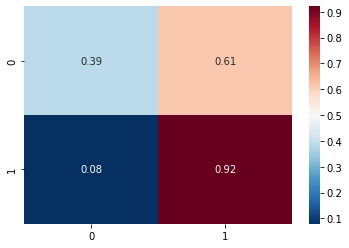

In [197]:
sns.heatmap(baseline_av.to_array(normalized=True), cmap='RdBu_r', annot=True, fmt='.2f')